## Cirhosis Prediction Dataset

#### About The Dataset
1) ID: unique identifier
2) N_Days: number of days between registration and the earlier of death, transplantation, or study analysis time in July 1986
3) Status: status of the patient C (censored), CL (censored due to liver tx), or D (death)
4) Drug: type of drug D-penicillamine or placebo
5) Age: age in [days]
6) Sex: M (male) or F (female)
7) Ascites: presence of ascites N (No) or Y (Yes)
8) Hepatomegaly: presence of hepatomegaly N (No) or Y (Yes)
9) Spiders: presence of spiders N (No) or Y (Yes)
10) Edema: presence of edema N (no edema and no diuretic therapy for edema), S (edema present without diuretics, or edema resolved by diuretics), or Y (edema despite diuretic therapy)
11) Bilirubin: serum bilirubin in [mg/dl]
12) Cholesterol: serum cholesterol in [mg/dl]
13) Albumin: albumin in [gm/dl]
14) Copper: urine copper in [ug/day]
15) Alk_Phos: alkaline phosphatase in [U/liter]
16) SGOT: SGOT in [U/ml]
17) Triglycerides: triglicerides in [mg/dl]
18) Platelets: platelets per cubic [ml/1000]
19) Prothrombin: prothrombin time in seconds [s]
20) Stage: histologic stage of disease (1, 2, 3, or 4)

In [91]:
import pandas as  pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import plotly.express as px
import missingno as msno
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE



import warnings
warnings.filterwarnings("ignore")

### Load and Check Data

In [2]:
df=pd.read_csv("cirrhosis.csv")
print(f" This dataset has {df.shape[0]} line and {df.shape[1]} columns")
df.head()

 This dataset has 418 line and 20 columns


ID  N_Days Status             Drug    Age Sex Ascites Hepatomegaly Spiders  \
0   1     400      D  D-penicillamine  21464   F       Y            Y       Y   
1   2    4500      C  D-penicillamine  20617   F       N            Y       Y   
2   3    1012      D  D-penicillamine  25594   M       N            N       N   
3   4    1925      D  D-penicillamine  19994   F       N            Y       Y   
4   5    1504     CL          Placebo  13918   F       N            Y       Y   

  Edema  Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos    SGOT  \
0     Y       14.5        261.0     2.60   156.0    1718.0  137.95   
1     N        1.1        302.0     4.14    54.0    7394.8  113.52   
2     S        1.4        176.0     3.48   210.0     516.0   96.10   
3     S        1.8        244.0     2.54    64.0    6121.8   60.63   
4     N        3.4        279.0     3.53   143.0     671.0  113.15   

   Tryglicerides  Platelets  Prothrombin  Stage  
0          172.0      190.0         12.2    4.0  
1           88.0      221.0         10.6    3.0  
2           55.0      151.0         12.0    4.0  
3           92.0      183.0         10.3    4.0  
4           72.0      136.0         10.9    3.0

In [3]:
df.drop(["ID"],axis=1,inplace=True) #removing ID column
df['Age'] = (df['Age'] / 365).astype(int) #Converting to year
df.head()

N_Days Status             Drug  Age Sex Ascites Hepatomegaly Spiders Edema  \
0     400      D  D-penicillamine   58   F       Y            Y       Y     Y   
1    4500      C  D-penicillamine   56   F       N            Y       Y     N   
2    1012      D  D-penicillamine   70   M       N            N       N     S   
3    1925      D  D-penicillamine   54   F       N            Y       Y     S   
4    1504     CL          Placebo   38   F       N            Y       Y     N   

   Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos    SGOT  Tryglicerides  \
0       14.5        261.0     2.60   156.0    1718.0  137.95          172.0   
1        1.1        302.0     4.14    54.0    7394.8  113.52           88.0   
2        1.4        176.0     3.48   210.0     516.0   96.10           55.0   
3        1.8        244.0     2.54    64.0    6121.8   60.63           92.0   
4        3.4        279.0     3.53   143.0     671.0  113.15           72.0   

   Platelets  Prothrombin  Stage  
0      190.0         12.2    4.0  
1      221.0         10.6    3.0  
2      151.0         12.0    4.0  
3      183.0         10.3    4.0  
4      136.0         10.9    3.0

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         418 non-null    int64  
 1   Status         418 non-null    object 
 2   Drug           312 non-null    object 
 3   Age            418 non-null    int32  
 4   Sex            418 non-null    object 
 5   Ascites        312 non-null    object 
 6   Hepatomegaly   312 non-null    object 
 7   Spiders        312 non-null    object 
 8   Edema          418 non-null    object 
 9   Bilirubin      418 non-null    float64
 10  Cholesterol    284 non-null    float64
 11  Albumin        418 non-null    float64
 12  Copper         310 non-null    float64
 13  Alk_Phos       312 non-null    float64
 14  SGOT           312 non-null    float64
 15  Tryglicerides  282 non-null    float64
 16  Platelets      407 non-null    float64
 17  Prothrombin    416 non-null    float64
 18  Stage     

In [5]:
df.describe().T

count         mean          std     min        25%      50%  \
N_Days         418.0  1917.782297  1104.672992   41.00  1092.7500  1730.00   
Age            418.0    50.382775    10.481084   26.00    42.0000    51.00   
Bilirubin      418.0     3.220813     4.407506    0.30     0.8000     1.40   
Cholesterol    284.0   369.510563   231.944545  120.00   249.5000   309.50   
Albumin        418.0     3.497440     0.424972    1.96     3.2425     3.53   
Copper         310.0    97.648387    85.613920    4.00    41.2500    73.00   
Alk_Phos       312.0  1982.655769  2140.388824  289.00   871.5000  1259.00   
SGOT           312.0   122.556346    56.699525   26.35    80.6000   114.70   
Tryglicerides  282.0   124.702128    65.148639   33.00    84.2500   108.00   
Platelets      407.0   257.024570    98.325585   62.00   188.5000   251.00   
Prothrombin    416.0    10.731731     1.022000    9.00    10.0000    10.60   
Stage          412.0     3.024272     0.882042    1.00     2.0000     3.00   

                   75%       max  
N_Days         2613.50   4795.00  
Age              58.00     78.00  
Bilirubin         3.40     28.00  
Cholesterol     400.00   1775.00  
Albumin           3.77      4.64  
Copper          123.00    588.00  
Alk_Phos       1980.00  13862.40  
SGOT            151.90    457.25  
Tryglicerides   151.00    598.00  
Platelets       318.00    721.00  
Prothrombin      11.10     18.00  
Stage             4.00      4.00

In [6]:
d=pd.DataFrame(df["Stage"].value_counts().reset_index())
d.columns=["Stage","Count"]

fig=px.pie (d,values="Count", names="Stage", hole=0.35, opacity=0.8,
            labels={"Stage": "Stage", "Count": "Number of Samples"})
fig.update_layout(title=dict(text= "Pie Chart Of Stage Feature"))
fig.update_traces(textposition="outside",textinfo="percent+label")
fig.show()

### Find Missing Value

In [7]:
df.isnull().sum()

N_Days             0
Status             0
Drug             106
Age                0
Sex                0
Ascites          106
Hepatomegaly     106
Spiders          106
Edema              0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
dtype: int64

In [8]:
categorical_cols=['Status', 'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema',"Stage"]
for col in categorical_cols:
    print(f"{col} unique values:\n{df[col].value_counts(dropna=False)}\n")


Status unique values:
Status
C     232
D     161
CL     25
Name: count, dtype: int64

Drug unique values:
Drug
D-penicillamine    158
Placebo            154
NaN                106
Name: count, dtype: int64

Sex unique values:
Sex
F    374
M     44
Name: count, dtype: int64

Ascites unique values:
Ascites
N      288
NaN    106
Y       24
Name: count, dtype: int64

Hepatomegaly unique values:
Hepatomegaly
Y      160
N      152
NaN    106
Name: count, dtype: int64

Spiders unique values:
Spiders
N      222
NaN    106
Y       90
Name: count, dtype: int64

Edema unique values:
Edema
N    354
S     44
Y     20
Name: count, dtype: int64

Stage unique values:
Stage
3.0    155
4.0    144
2.0     92
1.0     21
NaN      6
Name: count, dtype: int64



### Categorical Variables - Numerical Variables

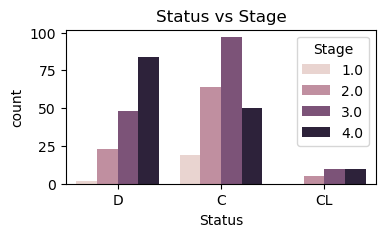

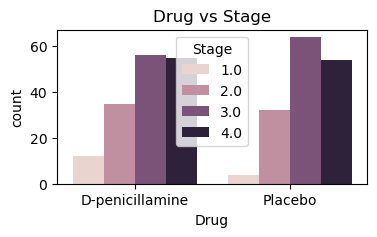

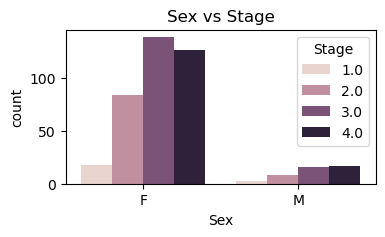

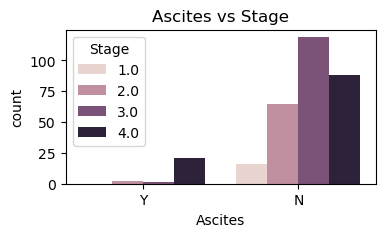

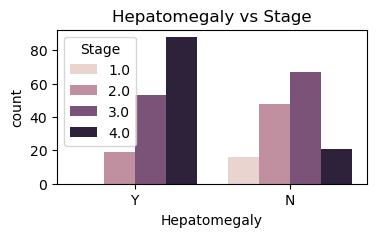

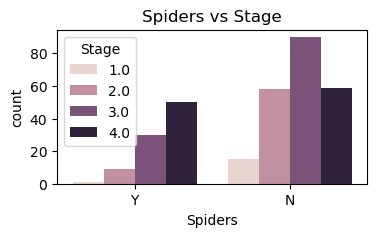

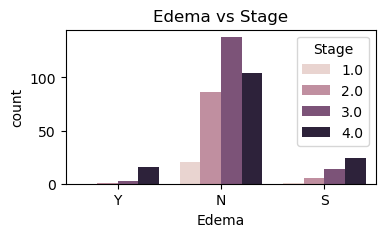

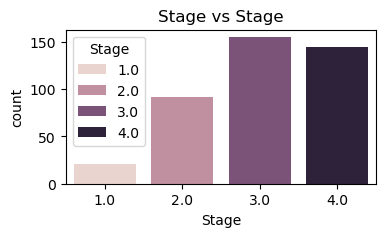

In [9]:
categorical_list=df[categorical_cols]

for i in categorical_list:
    plt.figure(figsize=(4,2))
    sns.countplot(x=i, data=categorical_list,hue="Stage")
    plt.title(f"{i} vs Stage")

* The risk of death increases in later stages, which is expected.
* The drug type does not make a significant difference in disease progression.
* Women are more prevalent in Stage 3 and 4, suggesting a possible gender effect.
* Ascites, hepatomegaly, and spiders appear more frequently as the disease progresses.
* Stage 3 and 4 are dominant, indicating a data imbalance that should be considered in modeling.
  *  In summary, some biological factors seem related to disease stage, drug effects are not significant, and there is a class imbalance.


In [10]:
numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns


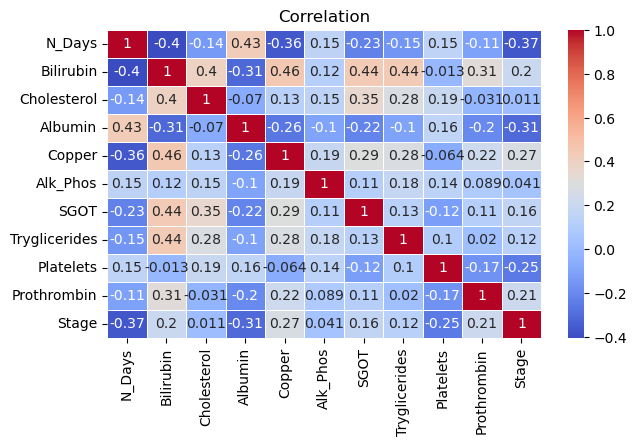

In [11]:
corr_matrix=df[numeric_cols].corr()

plt.figure(figsize=(7,4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation")
plt.show()

* Overall, there is no strong correlation with the Stage variable.
* N_Days (-0.37): As the disease progresses, survival time decreases.
* Albumin (-0.31): Lower albumin levels indicate more advanced disease stages.
* Platelets (-0.25): Low platelet count may be associated with disease progression.
* Bilirubin (0.2), Copper (0.27), Alk_Phos (0.27): These variables, related to liver damage, show a slight positive correlation with Stage.
* I will consider this information during data imputation and modeling.

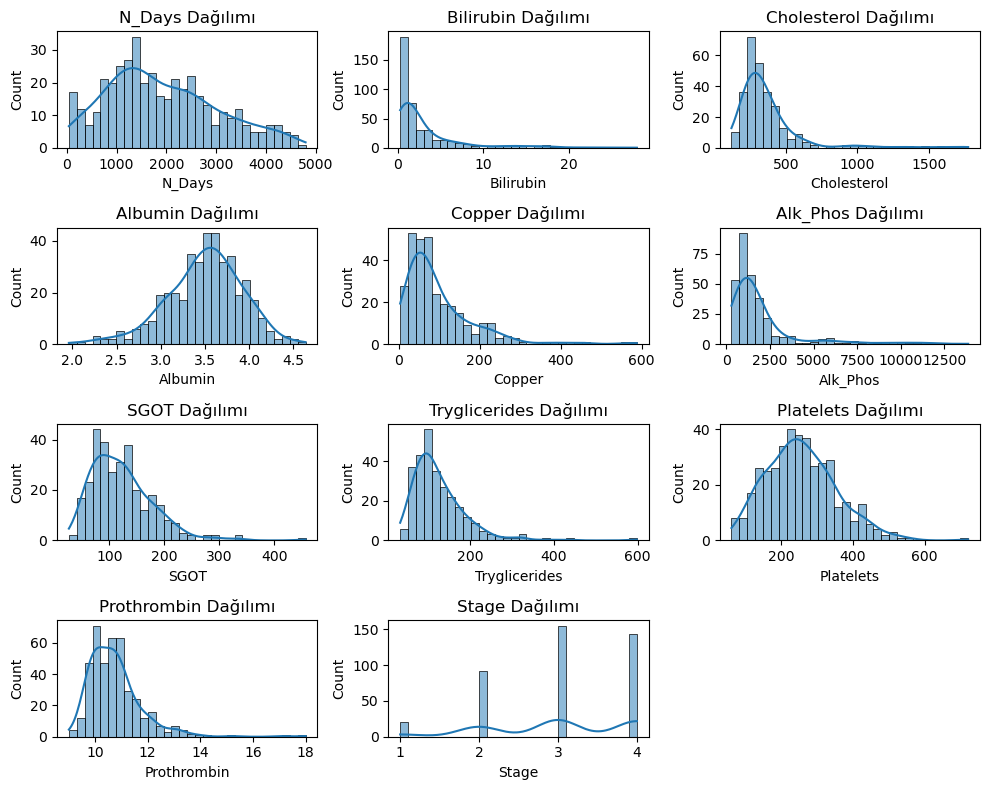

In [12]:
plt.figure(figsize=(10, 8))
for i, col in enumerate(numeric_cols):
    plt.subplot(len(numeric_cols) // 3 + 1, 3, i + 1)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"{col} Dağılımı")

plt.tight_layout()
plt.show()

* These graphs are histograms created to examine the distribution of numerical variables.
  - N_Days and Albumin variables have a more balanced distribution and appear closer to a normal distribution.
  - Bilirubin, Cholesterol, Copper, Alk_Phos, SGOT, Triglycerides, and Platelets variables exhibit a right-skewed distribution, meaning that lower values are more common, while higher values are rare.
  - Prothrombin shows a slightly right-skewed distribution but appears more balanced.
  - For Stage variable Stage 3 and 4 are more dominant.
* These distributions should be considered during missing data imputation and modeling. For right-skewed variables, robust imputation methods such as the median may be preferable.

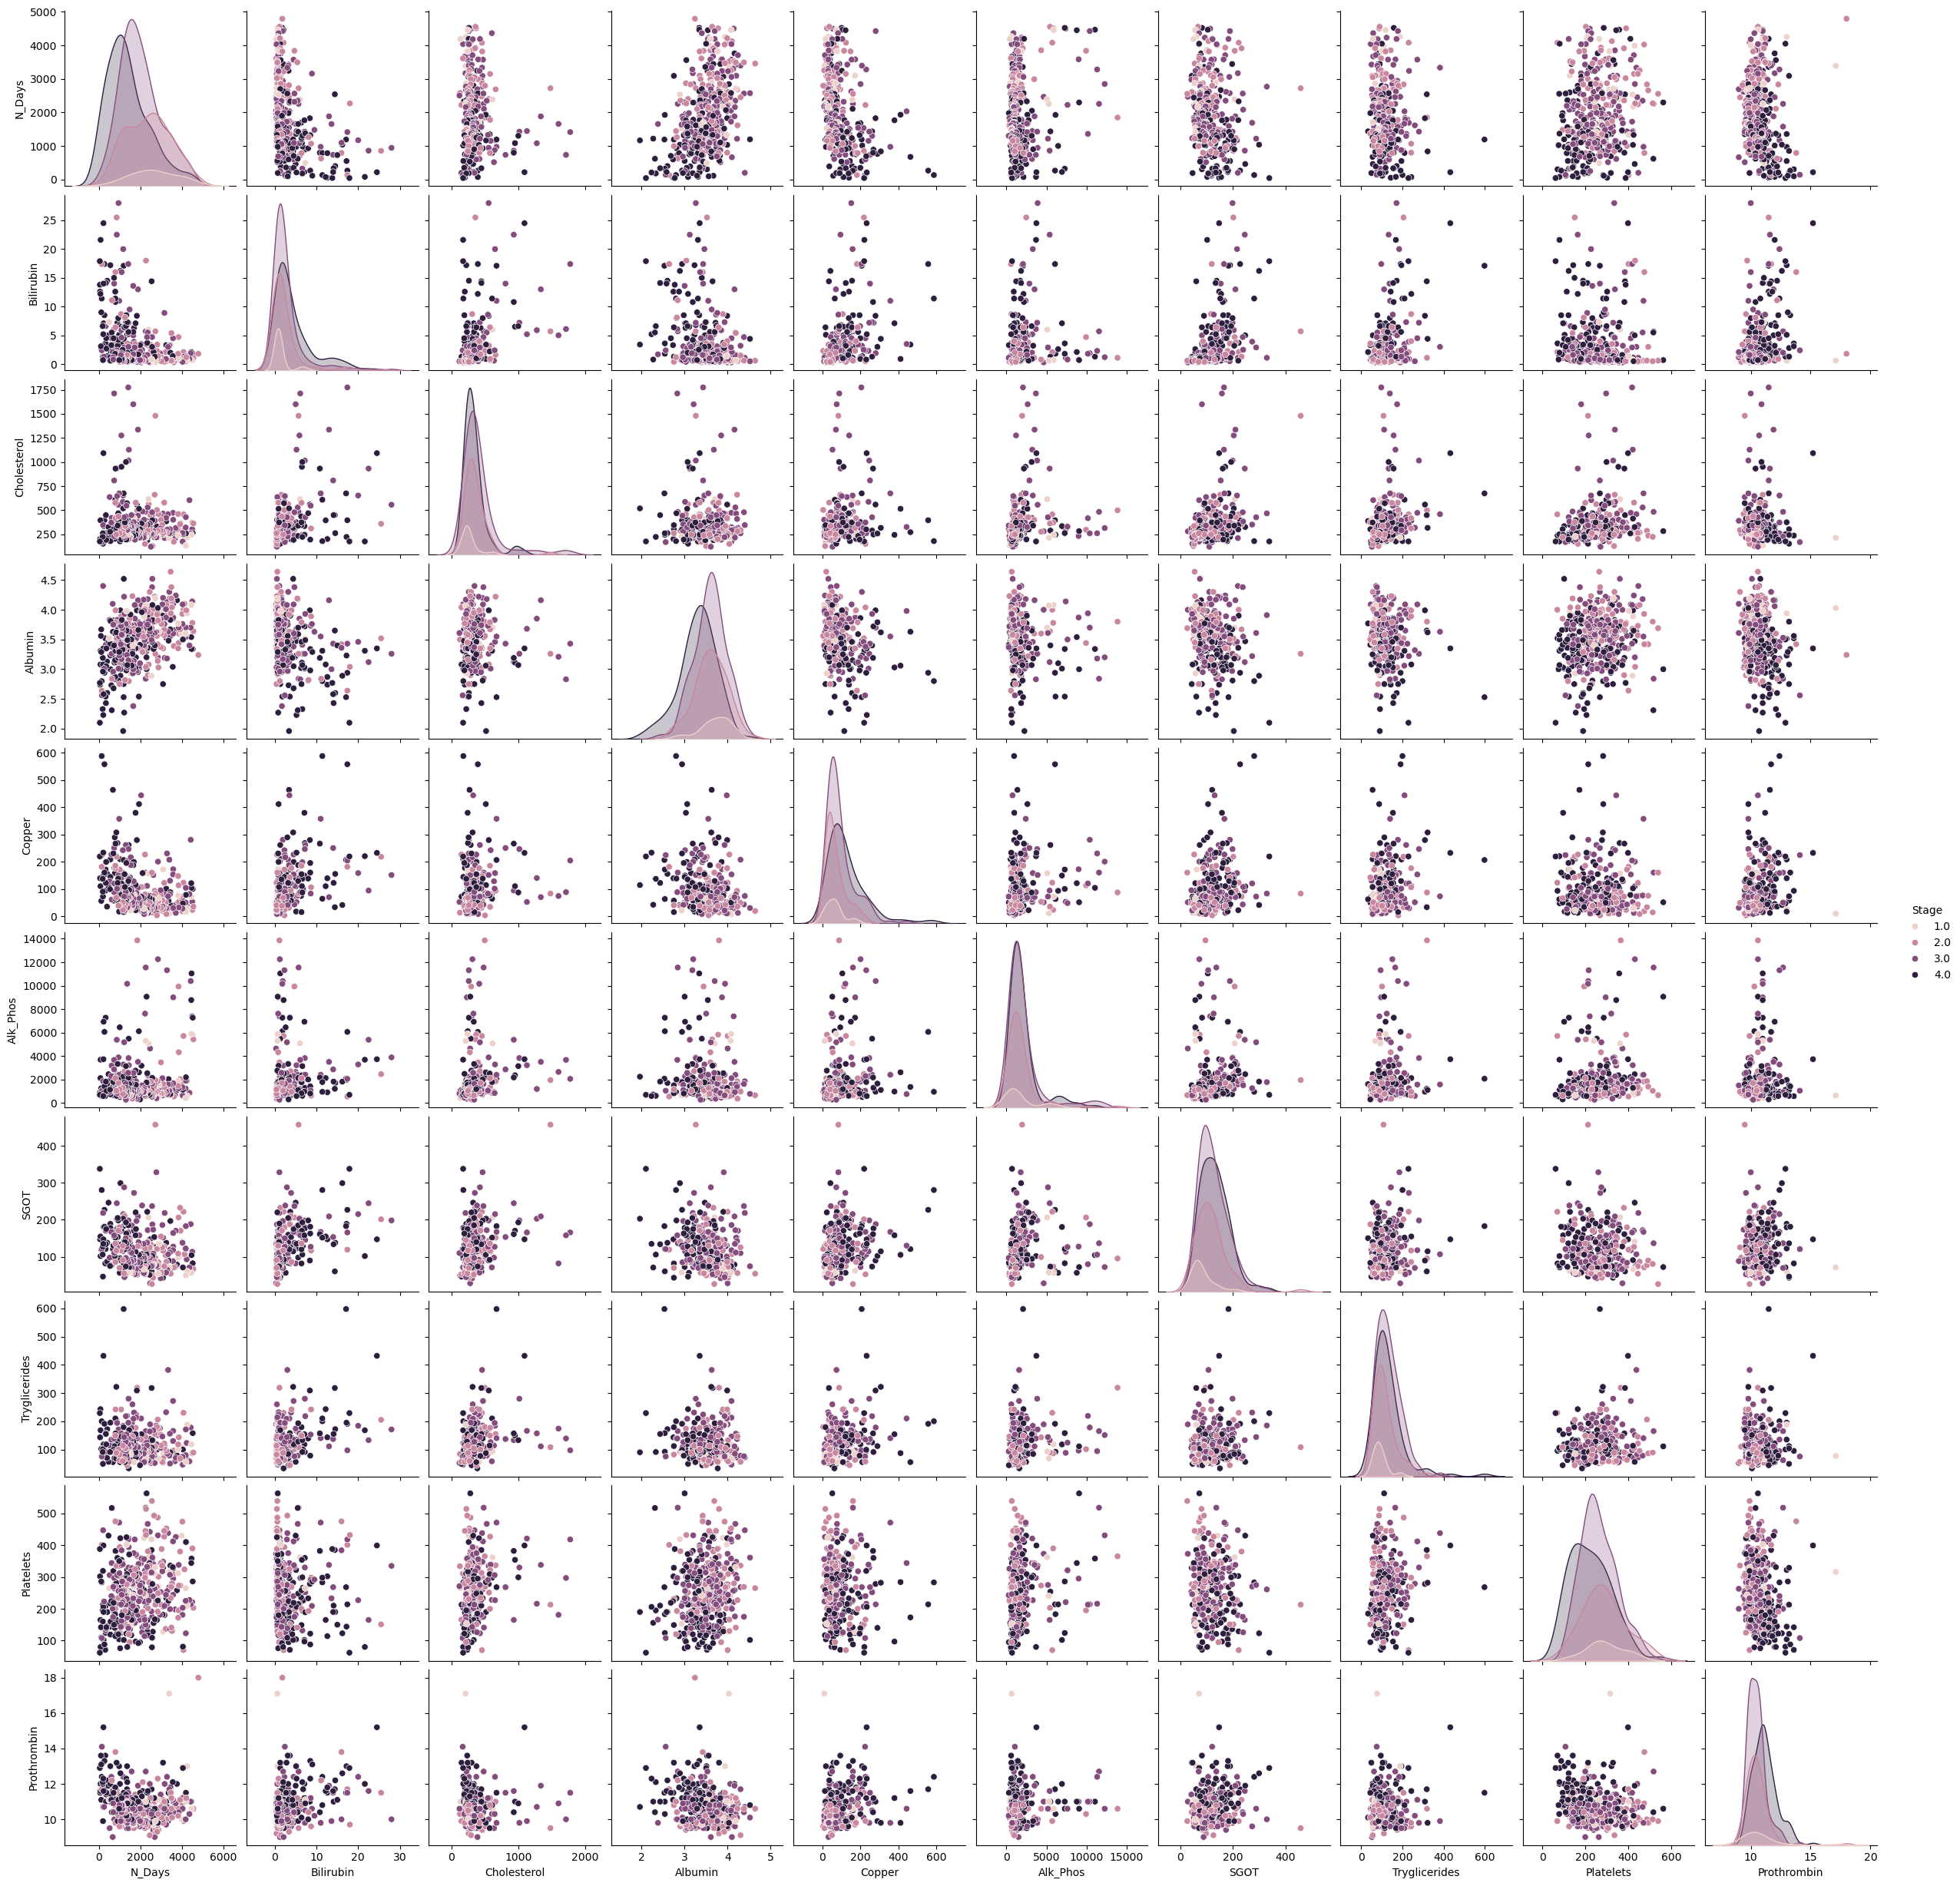

In [13]:
sns.pairplot(df[numeric_cols], hue="Stage", diag_kind="kde")
plt.show()

* This pairplot was created to visualize the relationships and distributions among numerical variables.
  - Variable distributions: Each variable’s individual distribution is displayed on the diagonal axis. Some are right-skewed, while others appear more balanced.
  - Pairwise relationships: Scatter plots allow us to examine whether there are linear or specific pattern-based relationships between variables.
  - Outliers: Some variables exhibit extreme values, which can be observed in the scatter plots.


### Analysis of Missing Values

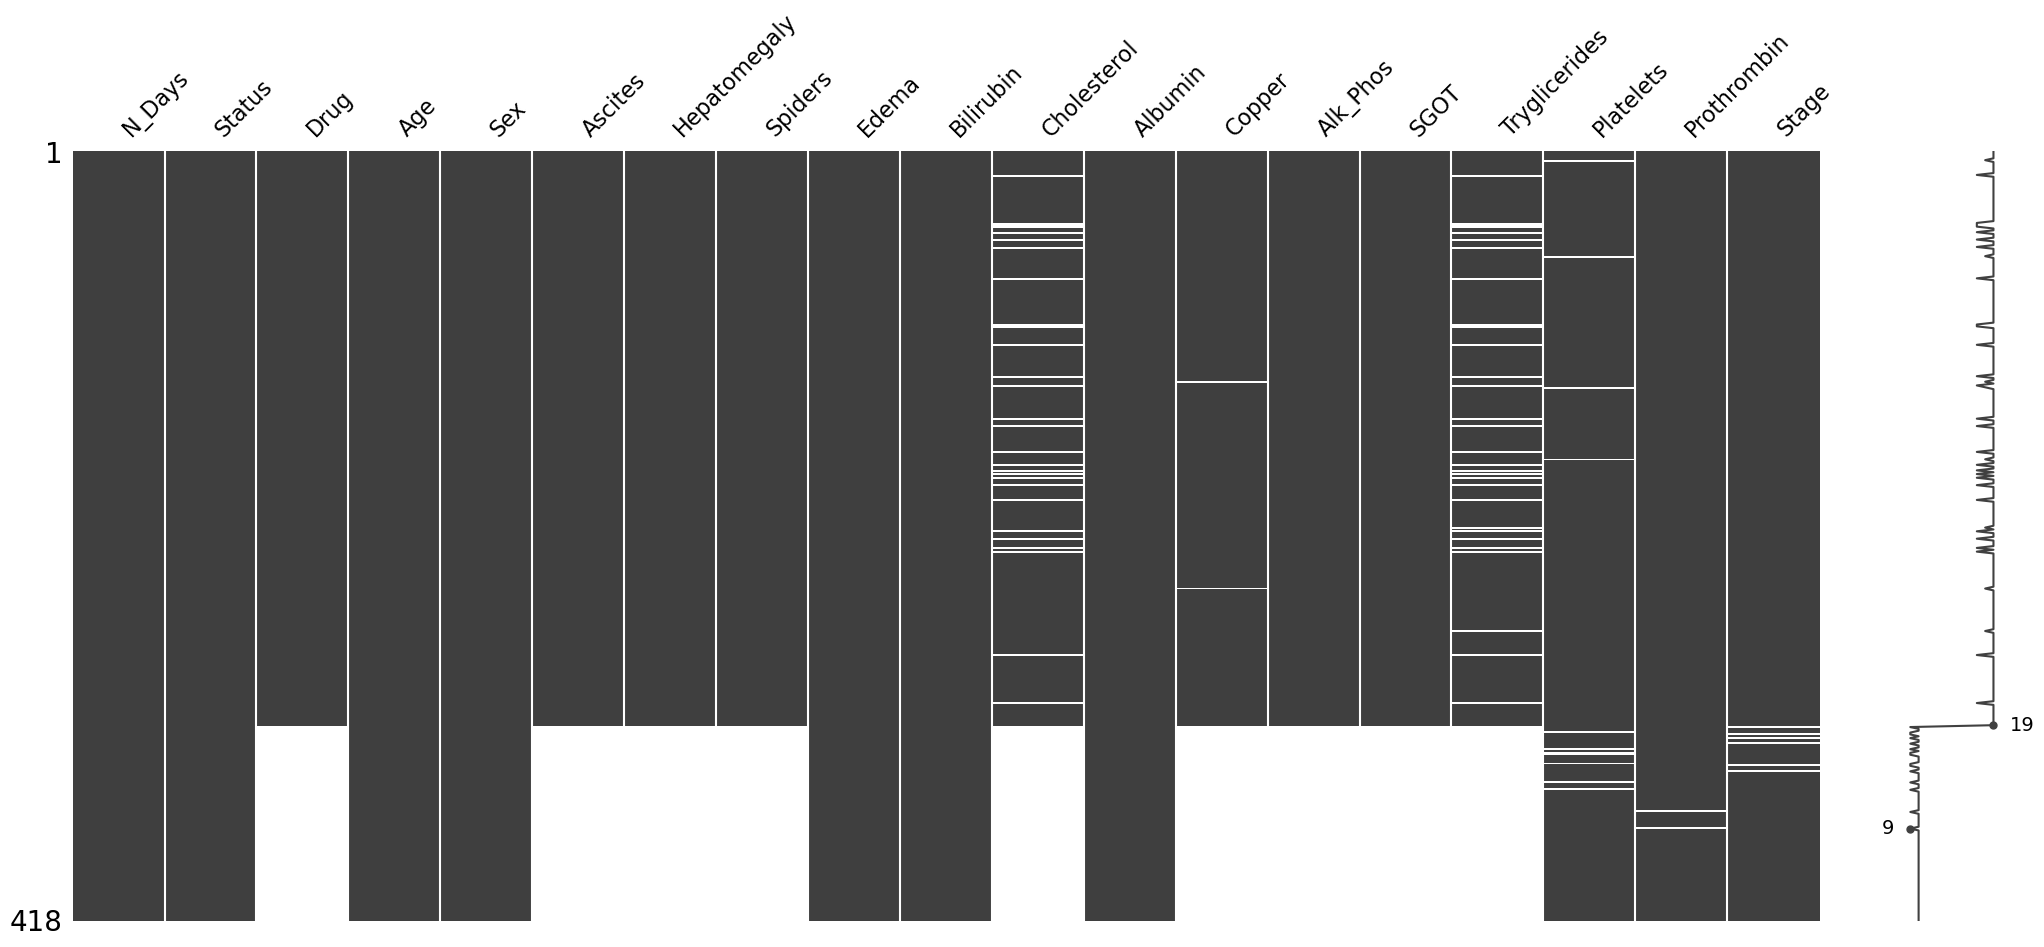

In [14]:
msno.matrix(df);

In [15]:
df.groupby("Stage").apply(lambda x: x.isnull().sum()).T

Stage          1.0  2.0  3.0  4.0
N_Days           0    0    0    0
Status           0    0    0    0
Drug             5   25   35   35
Age              0    0    0    0
Sex              0    0    0    0
Ascites          5   25   35   35
Hepatomegaly     5   25   35   35
Spiders          5   25   35   35
Edema            0    0    0    0
Bilirubin        0    0    0    0
Cholesterol      8   31   40   49
Albumin          0    0    0    0
Copper           5   26   35   36
Alk_Phos         5   25   35   35
SGOT             5   25   35   35
Tryglicerides    8   31   42   49
Platelets        1    6    2    2
Prothrombin      1    0    0    1
Stage            0    0    0    0

* To determine whether missing values are random or concentrated in specific groups and to establish a more accurate imputation strategy.
#### Note:
* Missing values increase as the Stage progresses, especially in Ascites, Hepatomegaly, Spiders, Cholesterol, and Triglycerides variables. This may be related to disease stage, but the data imbalance should not be overlooked. Since the number of patients in Stage 3 and 4 is higher, the absolute number of missing values may appear larger, which could be misleading.

## Outlier Detection

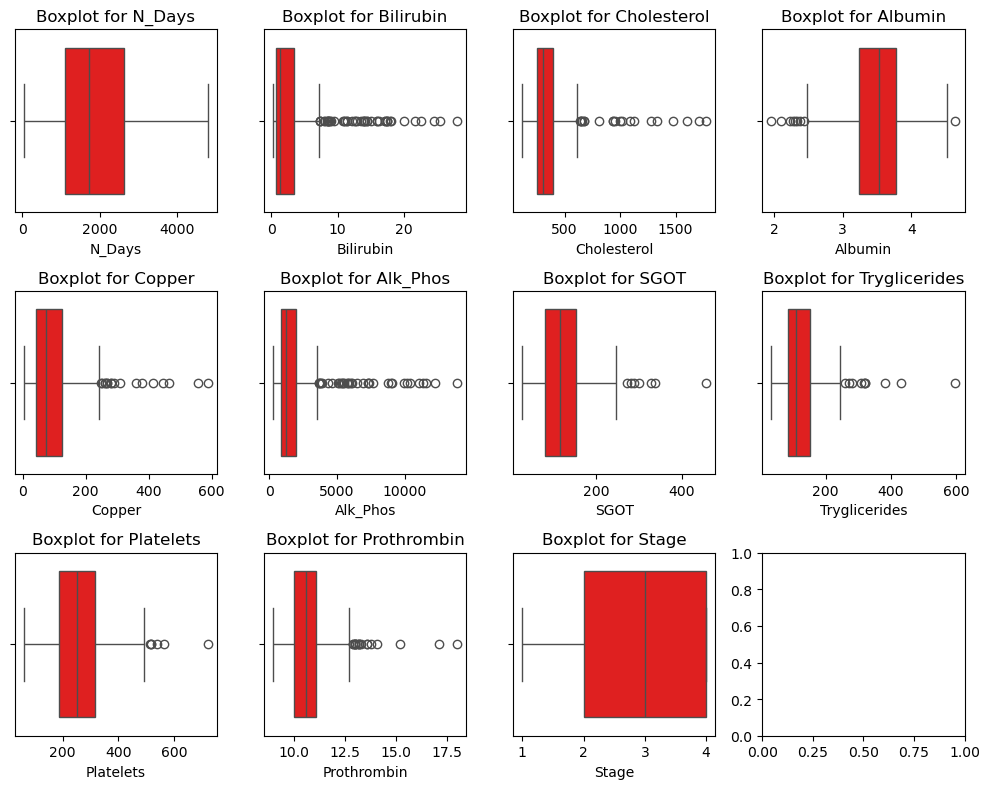

In [16]:
numeric_cols = df.select_dtypes(include=["float64", "int64"])
rows, cols = 3, 4
fig, axes = plt.subplots(rows, cols, figsize=(10, 8))

for i, col in enumerate(numeric_cols):
    ax = axes[i // cols, i % cols] 
    sns.boxplot(x=df[col].dropna(), vert=False, ax=ax, color="Red") # removing missing values
    ax.set_title(f"Boxplot for {col}", fontsize=12)
    ax.set_xlabel(col)
plt.tight_layout()
plt.show()

In [17]:
iqr_bounds = {}
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)

    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers_count = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()

    iqr_bounds[col] = {
        "Q1": Q1,
        "Q3": Q3,
        "IQR": IQR,
        "Lower Bound": lower_bound,
        "Upper Bound": upper_bound,
        "Outliers Count": outliers_count
    }
iqr_df = pd.DataFrame(iqr_bounds).T
iqr_df[['Q1', 'Q3', 'IQR', 'Lower Bound', 'Upper Bound', 'Outliers Count']]


Q1       Q3        IQR  Lower Bound  Upper Bound  \
N_Days         1092.7500  2613.50  1520.7500  -1188.37500   4894.62500   
Bilirubin         0.8000     3.40     2.6000     -3.10000      7.30000   
Cholesterol     249.5000   400.00   150.5000     23.75000    625.75000   
Albumin           3.2425     3.77     0.5275      2.45125      4.56125   
Copper           41.2500   123.00    81.7500    -81.37500    245.62500   
Alk_Phos        871.5000  1980.00  1108.5000   -791.25000   3642.75000   
SGOT             80.6000   151.90    71.3000    -26.35000    258.85000   
Tryglicerides    84.2500   151.00    66.7500    -15.87500    251.12500   
Platelets       188.5000   318.00   129.5000     -5.75000    512.25000   
Prothrombin      10.0000    11.10     1.1000      8.35000     12.75000   
Stage             2.0000     4.00     2.0000     -1.00000      7.00000   

               Outliers Count  
N_Days                    0.0  
Bilirubin                46.0  
Cholesterol              20.0  
Albumin                   9.0  
Copper                   17.0  
Alk_Phos                 35.0  
SGOT                      7.0  
Tryglicerides            10.0  
Platelets                 6.0  
Prothrombin              18.0  
Stage                     0.0

* Since the number of observations is small instead of removing outliers, We can apply winsorizing to reduce their effects. This means we will pull the outliers close to the upper and lower bounds, softening the extreme values. The methods to be used here are as follows:
  1. Winsorizing: Pulling outliers to the lower and upper bounds.
  2. Log transformation: Reducing large values and balancing the extreme values, resulting in a normal distribution.
  3. Square root and cubic root transformation: An alternative to log transformation, but can also be applied to negative values.
  4. Z-score: Detecting and removing extreme points based on standard deviation and the mean.

* While dealing with outliers, different methods can be applied to each variable. For example:
  - Bilirubin: There are many high outliers, winsorizing or log transformation can be applied.
  - Cholesterol: There are high extreme values, the distribution is right-skewed, winsorizing or log transformation can be applied.
  - Alk_Phos: There are extremely large outliers, winsorizing can be applied
  - Copper: Three extreme outliers are very dominant, winsorizing can be applied.
  - SGOT, Triglycerides, Prothrombin: Upper outliers are excessive, winsorizing can be applied.
  - Platelets: No large changes, no action is necessary



* However, since it’s not a real-life project and for simplicity, I will apply winsorizing to limit outliers for all variables here.



In [18]:
for col in numeric_cols:
    lower_bound = iqr_df.loc[col, "Lower Bound"]
    upper_bound = iqr_df.loc[col, "Upper Bound"]
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])


## Fill Missing Values
* Outlier analysis was performed and addressed before filling in the missing values. Now, I will re-look the changes in the distributions of the variables before imputation and try to determine the best strategy.

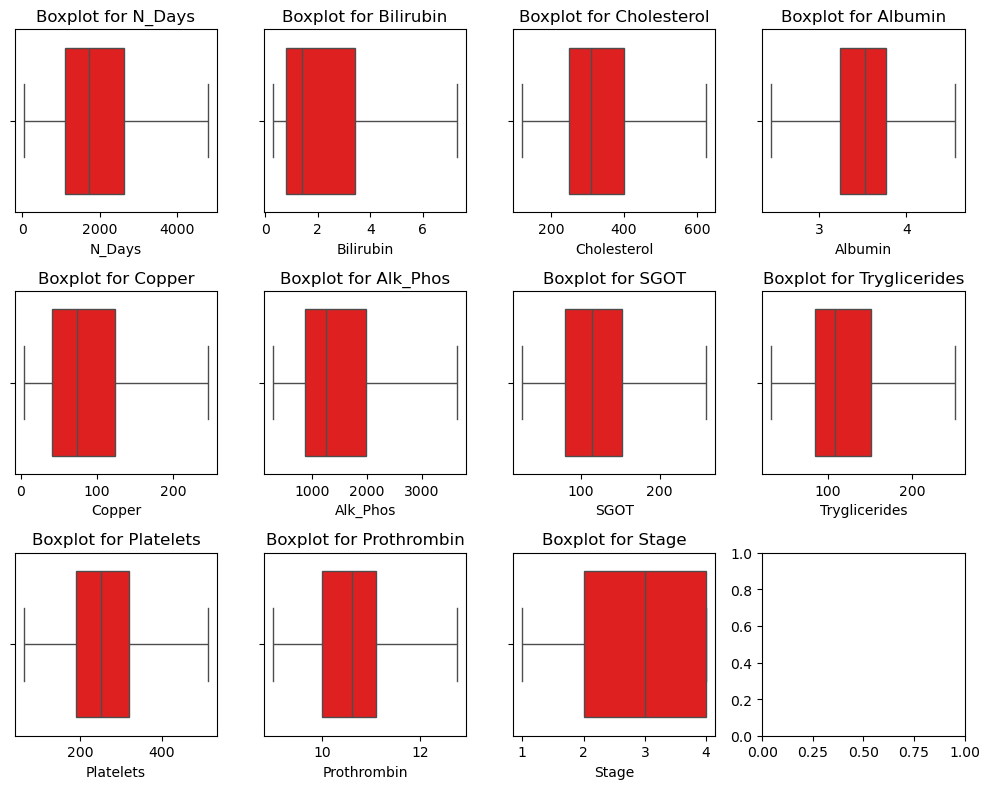

In [19]:
rows, cols = 3, 4
fig, axes = plt.subplots(rows, cols, figsize=(10, 8))

for i, col in enumerate(numeric_cols):
    ax = axes[i // cols, i % cols]
    sns.boxplot(x=df[col], ax=ax, color="red")
    ax.set_title(f"Boxplot for {col}", fontsize=12)
plt.tight_layout()
plt.show()

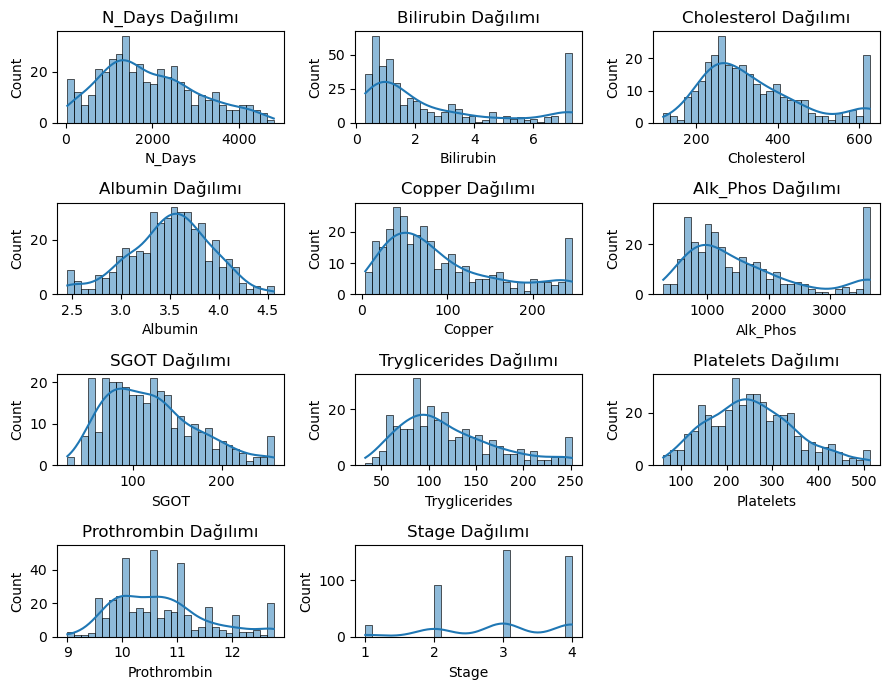

In [20]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(9, 7))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.histplot(df[col], kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f"{col} Dağılımı")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()


In [21]:
missing_counts = df.isnull().sum()
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)
print(missing_counts)

Tryglicerides    136
Cholesterol      134
Copper           108
Drug             106
Ascites          106
Hepatomegaly     106
Spiders          106
Alk_Phos         106
SGOT             106
Platelets         11
Stage              6
Prothrombin        2
dtype: int64


In [22]:
# First, let's take a look at the stage variable
df[df["Stage"].isnull()]


N_Days Status Drug  Age Sex Ascites Hepatomegaly Spiders Edema  \
312  4062.0      C  NaN   60   F     NaN          NaN     NaN     N   
316  3030.0      C  NaN   62   F     NaN          NaN     NaN     N   
318    41.0      D  NaN   46   F     NaN          NaN     NaN     N   
321  2011.0      D  NaN   64   F     NaN          NaN     NaN     N   
333   466.0      D  NaN   56   F     NaN          NaN     NaN     N   
336  2286.0      D  NaN   56   F     NaN          NaN     NaN     N   

     Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos  SGOT  Tryglicerides  \
312        0.7          NaN     3.65     NaN       NaN   NaN            NaN   
316        0.8          NaN     2.48     NaN       NaN   NaN            NaN   
318        5.0          NaN     2.93     NaN       NaN   NaN            NaN   
321        1.1          NaN     3.69     NaN       NaN   NaN            NaN   
333        7.1          NaN     3.51     NaN       NaN   NaN            NaN   
336        1.8          NaN     3.64     NaN       NaN   NaN            NaN   

     Platelets  Prothrombin  Stage  
312     378.00         11.0    NaN  
316     273.00         10.0    NaN  
318     260.00         10.4    NaN  
321     139.00         10.5    NaN  
333     512.25         11.8    NaN  
336     141.00         10.0    NaN

In [23]:
df = df[df["Stage"].notnull()]
df[df["Stage"].isnull()]


Empty DataFrame
Columns: [N_Days, Status, Drug, Age, Sex, Ascites, Hepatomegaly, Spiders, Edema, Bilirubin, Cholesterol, Albumin, Copper, Alk_Phos, SGOT, Tryglicerides, Platelets, Prothrombin, Stage]
Index: []

In [24]:
# For right-skewed variables -> fill with median
for col in ["Bilirubin", "Cholesterol", "Copper", "Alk_Phos", "Tryglicerides", "SGOT", "Prothrombin"]:
    df[col].fillna(df[col].median(), inplace=True)

# For variables close to normal distribution -> fill with mean
for col in ["Albumin", "Platelets"]:
    df[col].fillna(df[col].mean(), inplace=True)

# For categorical variables -> fill with mode
for col in ["Drug", "Ascites", "Hepatomegaly", "Spiders"]:
    df[col].fillna(df[col].mode()[0], inplace=True)


In [25]:
df.isnull().sum().sum() 

0

## Preparation for Modelling

In [26]:
encoder = LabelEncoder()

# For binary categorical variables -> label encoding
# Binary variables like "Sex", "Ascites", "Hepatomegaly", "Spiders", and "Drug" are encoded using label encoding (0 or 1)
binary_cols = ["Sex", "Ascites", "Hepatomegaly", "Spiders", "Drug"]

for col in binary_cols:
    df[col] = encoder.fit_transform(df[col])  # Label encoding

# For categorical variables with more than two classes -> one-hot encoding
# For variables like "Status" and "Edema" that have more than two categories, one-hot encoding is applied 

df = pd.get_dummies(df, columns=["Status", "Edema"], drop_first=True) # with drop_first=True to avoid the dummy variable trap (reducing multicollinearity)
df.head()

N_Days  Drug  Age  Sex  Ascites  Hepatomegaly  Spiders  Bilirubin  \
0   400.0     0   58    0        1             1        1        7.3   
1  4500.0     0   56    0        0             1        1        1.1   
2  1012.0     0   70    1        0             0        0        1.4   
3  1925.0     0   54    0        0             1        1        1.8   
4  1504.0     1   38    0        0             1        1        3.4   

   Cholesterol  Albumin  ...  Alk_Phos    SGOT  Tryglicerides  Platelets  \
0        261.0     2.60  ...   1718.00  137.95          172.0      190.0   
1        302.0     4.14  ...   3642.75  113.52           88.0      221.0   
2        176.0     3.48  ...    516.00   96.10           55.0      151.0   
3        244.0     2.54  ...   3642.75   60.63           92.0      183.0   
4        279.0     3.53  ...    671.00  113.15           72.0      136.0   

   Prothrombin  Stage  Status_CL  Status_D  Edema_S  Edema_Y  
0         12.2    4.0      False      True    False     True  
1         10.6    3.0      False     False    False    False  
2         12.0    4.0      False      True     True    False  
3         10.3    4.0      False      True     True    False  
4         10.9    3.0       True     False    False    False  

[5 rows x 21 columns]

In [27]:
### Let's define the X and y variables.
X=df.drop(["Stage"],axis=1) 
y=df[["Stage"]] # target variable


In [28]:
# Splitting training test and test set 
X_train, X_test, y_train, y_test=train_test_split (X, y,
                                                   test_size=0.15,
                                                   random_state=42)  

print(f"X_Train set: {X_train.shape}")
print(f"X_Test set: {X_test.shape}")
print(f"y_Train set: {y_train.shape}")
print(f"y_Test set: {y_test.shape}")


X_Train set: (350, 20)
X_Test set: (62, 20)
y_Train set: (350, 1)
y_Test set: (62, 1)


# RF MODELS COMPARISING 

* Now, I will build a very simple model, and due to data imbalance, the score is likely to be low. Then, I will analyze feature importance and retrain the model. After that, we will add synthetic data and compare different models. Finally, we will apply all models and fine-tune hyperparameters using GridSearchCV.

##  Basic Random Forests Model

In [29]:
rf_model=RandomForestClassifier(n_estimators=100,random_state=1) #n_estimators=100 (default)
rf_model.fit(X_train,y_train)

RandomForestClassifier(random_state=1)

In [30]:
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Train Accuracy: {train_acc:.2f}")
print(f"Test Accuracy: {test_acc:.2f}")

Train Accuracy: 1.00
Test Accuracy: 0.52


## Removing Features of Low Importance and Comparing
* Now let's look at the variable importance and drop the low importance features and re-build model.

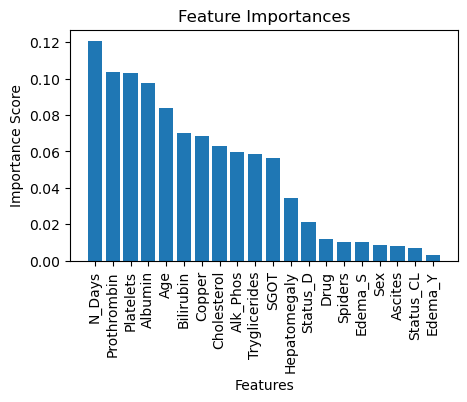

In [31]:
importances = rf_model.feature_importances_
feature_names = X_train.columns

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(5,3))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.show()

In [32]:
feature_names

Index(['N_Days', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders',
       'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT',
       'Tryglicerides', 'Platelets', 'Prothrombin', 'Status_CL', 'Status_D',
       'Edema_S', 'Edema_Y'],
      dtype='object')

In [33]:
#dropping low importance features 
low_importance_features = ["Edema_Y", "Status_CL","Sex", "Edema_S", "Ascites","Drug","Spiders"]
X_train_new = X_train.drop(columns=low_importance_features)
X_test_new = X_test.drop(columns=low_importance_features)

In [34]:
rf_model_new=RandomForestClassifier(random_state=1)
rf_model_new.fit(X_train_new,y_train)

RandomForestClassifier(random_state=1)

In [35]:
y_train_pred_new= rf_model_new.predict(X_train_new)
y_test_pred_new= rf_model_new.predict(X_test_new)

In [36]:
train_acc_new = accuracy_score(y_train, y_train_pred_new)
test_acc_new = accuracy_score(y_test, y_test_pred_new)

print(f"Train Accuracy (new Features): {train_acc_new:.2f}")
print(f"Test Accuracy (new Features): {test_acc_new:.2f}")

Train Accuracy (new Features): 1.00
Test Accuracy (new Features): 0.53


## SMOTE
* I will add synthetic data with SMOTE , but there are some key points to consider.


  - First, I  will add synthetic data after removing low-importance features, as want the model to focus only on truly meaningful features.

* When adding synthetic data, there are different methods, each with its own advantages and disadvantages. Approaches such as adding synthetic data only to the training set, generating synthetic data proportionally based on class imbalance, or applying synthetic data to the entire dataset can be used.
    
    -  Here, I will apply SMOTE to the entire dataset, as I am exploring different alternatives to improve model performance.


In [37]:
X_filtered=X.drop(columns=low_importance_features) #droppped low importances features
X_filtered.shape

(412, 13)

In [38]:
smote = SMOTE(random_state=1)
X_resampled, y_resampled = smote.fit_resample(X_filtered, y) 


In [39]:
X_resampled_train, X_resampled_test, y_resampled_train, y_resampled_test= train_test_split(X_resampled, y_resampled,
                                                                                          test_size=0.15, random_state=42)

In [40]:
# now re-building basic rf model for comparising 
rf_resampled= RandomForestClassifier(n_estimators=100, random_state=1)
rf_resampled.fit(X_resampled_train, y_resampled_train)

RandomForestClassifier(random_state=1)

In [90]:
y_train_resampled_pred= rf_resampled.predict(X_resampled_train)
y_test_resampled_pred= rf_resampled.predict(X_resampled_test)

train_resampled_acc= accuracy_score(y_resampled_train, y_train_resampled_pred)
test_resampled_acc=accuracy_score(y_resampled_test, y_test_resampled_pred)

print(f" RF Train Accuracy (SMOTE): {train_resampled_acc:.2f}")
print(f" RF Test Accuracy (SMOTE): {test_resampled_acc:.2f}")


 RF Train Accuracy (SMOTE): 1.00
 RF Test Accuracy (SMOTE): 0.59


# Models
* First, I am analyzing how all models perform with their default (basic) settings. At this stage, I expect the test accuracy to be low because the models have not been optimized yet. However, I am doing this to better observe the impact of improvements during the upcoming hyperparameter tuning phase. In the next step, I will use GridSearchCV to find the best parameters for each model and analyze the performance differences.

* I have already checked the accuracy of the Random Forest model with its default params.

## Decision Tree

In [42]:
X_resampled_train.shape

(527, 13)

In [43]:
y_resampled_train.shape

(527, 1)

In [44]:
dt_model=DecisionTreeClassifier(random_state=1)
dt_model.fit(X_resampled_train,y_resampled_train)

DecisionTreeClassifier(random_state=1)

In [45]:
y_train_resampled_pred= dt_model.predict(X_resampled_train)
y_test_resampled_pred= dt_model.predict(X_resampled_test)

train_resampled_acc= accuracy_score(y_resampled_train, y_train_resampled_pred)
test_resampled_acc=accuracy_score(y_resampled_test, y_test_resampled_pred)

print(f" DT Train Accuracy (SMOTE): {train_resampled_acc:.4f}")
print(f" DT Test Accuracy (SMOTE): {test_resampled_acc:.4f}")


 DT Train Accuracy (SMOTE): 1.0000
 DT Test Accuracy (SMOTE): 0.4731


## CatBoost
*  I planned to apply XGBoost, but since XGBoost requires class labels to start from 0, I would have had to modify the target variable. To avoid unnecessary adjustments and to explore another powerful boosting algorithm, I decided to apply CatBoost instead.

In [46]:
cat_model = CatBoostClassifier(random_state=1, verbose=0)
cat_model.fit(X_resampled_train, y_resampled_train)

In [47]:
y_train_resampled_pred = cat_model.predict(X_resampled_train)
y_test_resampled_pred = cat_model.predict(X_resampled_test)

train_resampled_acc = accuracy_score(y_resampled_train, y_train_resampled_pred)
test_resampled_acc = accuracy_score(y_resampled_test, y_test_resampled_pred)

print(f"CatBoost Train Accuracy (SMOTE): {train_resampled_acc:.4f}")
print(f"CatBoost Test Accuracy (SMOTE): {test_resampled_acc:.4f}")

CatBoost Train Accuracy (SMOTE): 1.0000
CatBoost Test Accuracy (SMOTE): 0.5699


##  Hyperparameter Tuning - GridSearchCV - Cross Validation

* Now that I have trained the basic versions of Random Forest, Decision Tree, and CatBoost, I will proceed with hyperparameter tuning. In this step, I will optimize the models by finding the best parameters using GridSearchCV. To ensure better generalization and reduce overfitting, I will evaluate the models using cross-validation accuracy during the tuning process. Once the best parameters are found, I will re-train the models and compare their final performances using train-test accuracy.

In [75]:
random_state = 1

classifiers = [
    DecisionTreeClassifier(random_state=random_state),
    RandomForestClassifier(random_state=random_state),
    CatBoostClassifier(random_state=random_state, verbose=0)
]

# Hyperparameter grids
dt_param_grid = {
    "min_samples_split": range(2, 40, 2),
    "max_depth": range(1, 15, 2),
    "min_samples_leaf": [1, 2, 4]
}
rf_param_grid = {
    "max_features": [1, 3, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 3, 10],
    "bootstrap": [False],
    "n_estimators": [40,100,250],
    "criterion": ["gini"]
}
cat_param_grid = {
    "depth": [4, 6, 8],
    "iterations": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 0.2]
}

classifier_params = [dt_param_grid, rf_param_grid, cat_param_grid]

# let's make a dictionary for results 
best_estimators_dict = {}
cv_results=[]

In [76]:
#GridSearchCV
for clf, params in zip (classifiers, classifier_params):

    # optimization with GridSearchCV
    grid_search = GridSearchCV(clf,
                               param_grid=params,
                               cv=StratifiedKFold(n_splits=5), scoring="accuracy",
                               n_jobs=-1,
                               verbose=1)
    grid_search.fit(X_resampled_train, y_resampled_train) 

    # now Let's append best parameters and scores to dictionary
    best_estimators_dict[clf.__class__.__name__] = {
        "best_model": grid_search.best_estimator_,
        "best_params": grid_search.best_params_,
        "best_score": grid_search.best_score_
    }
    cv_results.append(grid_search.best_score_)    

Fitting 5 folds for each of 399 candidates, totalling 1995 fits
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [77]:
cv_results_df = pd.DataFrame({
    "Model": list(best_estimators_dict.keys()),
    "Best Cross-Validation Accuracy": [best_estimators_dict[m]["best_score"] for m in best_estimators_dict]
})

In [78]:
# let's look at the best parameters for each model
for model_name, model_data in best_estimators_dict.items():
    print(f"\n {model_name} - Best Parameters: {model_data['best_params']}")


 DecisionTreeClassifier - Best Parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}

 RandomForestClassifier - Best Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 250}

 CatBoostClassifier - Best Parameters: {'depth': 8, 'iterations': 200, 'learning_rate': 0.2}


In [79]:
cv_results_df

Model  Best Cross-Validation Accuracy
0  DecisionTreeClassifier                        0.536999
1  RandomForestClassifier                        0.677341
2      CatBoostClassifier                        0.681150

##  Final Model and Performance Analysis 
In this section:
* I will re-build the Random Forest model with the best parameters.
* Accuracy, Confusion Matrix, Classification Report
* Finally, I will analyze the results and evaluate the overall performance of the model.

In [86]:
rf_final = RandomForestClassifier(bootstrap=False,
                                 criterion="gini",
                                 max_features=1,
                                 min_samples_leaf=1,
                                 min_samples_split=2,
                                 n_estimators=250,
                                 random_state=1)

rf_final.fit(X_resampled_train, y_resampled_train)

RandomForestClassifier(bootstrap=False, max_features=1, n_estimators=250,
                       random_state=1)

In [103]:
y_test_pred = rf_final.predict(X_resampled_test)
test_acc = accuracy_score(y_resampled_test, y_test_pred)

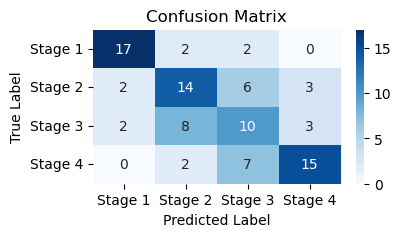

 Final Model Test Accuracy: 0.60
              precision    recall  f1-score   support

         1.0       0.81      0.81      0.81        21
         2.0       0.54      0.56      0.55        25
         3.0       0.40      0.43      0.42        23
         4.0       0.71      0.62      0.67        24

    accuracy                           0.60        93
   macro avg       0.62      0.61      0.61        93
weighted avg       0.61      0.60      0.61        93



In [104]:
#confusion matrix 
class_names = ["Stage 1", "Stage 2", "Stage 3", "Stage 4"]
conf_matrix = confusion_matrix(y_resampled_test, y_test_pred)


plt.figure(figsize=(4,2))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print(f" Final Model Test Accuracy: {test_acc:.2f}")
print(classification_report(y_resampled_test, y_test_pred))

* The following metrics are used to evaluate the model's performance. Since this is not a real-world project, only the functions of the metrics are explained.
  - Confusion Matrix : Shows which classes the model predicts correctly and which ones it confuses with each other.
  - Accuracy : Indicates how accurately the model predicts across all classes.
  - Precision : Measures how correct the model’s predictions are for a specific class. It decreases when there are too many false positives (FP).
  - Recall (Sensitivity) : Indicates how well the model captures a specific class. It decreases when there are too many false negatives (FN).
  -  F1-Score : Provides a balanced evaluation of Precision and Recall. If either is low, the F1-score also decreases.
  -  Support : Shows the number of actual instances for each class, meaning the count of observations used for model evaluation.


# Final Model Evaluation and Summary

## 1- Project Overview: 
In this project, I developed a classification model to predict the stage of liver cirrhosis based on various medical features.  
I applied data preprocessing, feature selection, SMOTE balancing, and hyperparameter tuning to improve model performance.


## 2- Final Model Selection :
After comparing multiple models, I selected Random Forest as the final model.  

## 3- Model Performance :
**1.** **Test Accuracy :**
  * The final model achieved a test accuracy of 60%, which is slightly lower than the cross-validation accuracy (67%).
  * This indicates that the model generalizes relatively well but still has room for improvement.

**2.** **Confusion Matrix :**
  * Stage 1 was the easiest to classify (81% recall).
  * Stage 3 had the most misclassifications (43% recall).
 
**3.** **Classification Report :**
  * Precision and Recall vary across different stages, indicating some classes are easier to classify than others.

## 4- Key Takeaways:
*  Feature Selection and SMOTE improved the model's robustness.
*  Hyperparameter tuning helped in optimizing the Random Forest model.
*  The accuracy (60%) is reasonable, but further improvement can be made.

## 5- Possible Future Improvements: 
* Feature Engineering: Extracting better features to improve classification.
* Trying Other Models: XGBoost, CatBoost, or Ensemble Models could be tested.
* Addressing Class Imbalance: More data collection or advanced balancing techniques.

## 6- Conclusion: 
 This project successfully developed a Random Forest-based cirrhosis stage classifier with an accuracy of 60% on unseen test data.
While the model performs well in certain areas, additional optimizations and data enhancements could further improve accuracy.